In [ ]:
import numpy as np
import random
from collections import defaultdict

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Objective functions
def f1(x):
    return (x - 2) ** 2

def f2(x):
    return (x + 2) ** 2

# Population initialization
def initialize_population(size, bounds):
    return [random.uniform(bounds[0], bounds[1]) for _ in range(size)]

# Evaluation
def evaluate_population(population):
    return [(f1(x), f2(x)) for x in population]

# Dominance
def dominates(obj1, obj2):
    return all(x <= y for x, y in zip(obj1, obj2)) and any(x < y for x, y in zip(obj1, obj2))

# Non-dominated sorting
def fast_nondominated_sort(objectives):
    population_size = len(objectives)
    S = [[] for _ in range(population_size)]
    n = [0] * population_size
    rank = [0] * population_size
    fronts = [[]]

    for p in range(population_size):
        for q in range(population_size):
            if dominates(objectives[p], objectives[q]):
                S[p].append(q)
            elif dominates(objectives[q], objectives[p]):
                n[p] += 1
        if n[p] == 0:
            rank[p] = 0
            fronts[0].append(p)

    i = 0
    while fronts[i]:
        next_front = []
        for p in fronts[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    next_front.append(q)
        i += 1
        fronts.append(next_front)
    fronts.pop()
    return fronts

# Generate reference points
def generate_reference_points(M, p):
    """Generates reference points uniformly on the unit simplex in M dimensions."""
    def generate_recursive(points, num_objs, left, total, depth, current_point):
        if depth == num_objs - 1:
            current_point.append(left / total)
            points.append(current_point.copy())
            current_point.pop()
        else:
            for i in range(left + 1):
                current_point.append(i / total)
                generate_recursive(points, num_objs, left - i, total, depth + 1, current_point)
                current_point.pop()
    points = []
    generate_recursive(points, M, p, p, 0, [])
    return np.array(points)

# Environmental selection
def environmental_selection(population, objectives, fronts, reference_points, pop_size):
    next_population_indices = []
    for front in fronts:
        if len(next_population_indices) + len(front) <= pop_size:
            next_population_indices.extend(front)
        else:
            N = pop_size - len(next_population_indices)
            selected_indices = niching_selection(front, objectives, reference_points, N)
            next_population_indices.extend(selected_indices)
            break
    next_population = [population[i] for i in next_population_indices]
    return next_population

# Niching selection
def niching_selection(front, objectives, reference_points, N):
    selected = []
    # Normalize objectives
    objs = np.array([objectives[i] for i in front])
    ideal_point = np.min(objs, axis=0)
    normalized_objs = objs - ideal_point

    # Avoid division by zero
    max_values = np.max(normalized_objs, axis=0)
    max_values[max_values == 0] = 1
    normalized_objs = normalized_objs / max_values

    # Associate each individual with the nearest reference point
    associations = []
    for idx, obj in zip(front, normalized_objs):
        distances = np.linalg.norm(obj - reference_points, axis=1)
        min_index = np.argmin(distances)
        associations.append((idx, min_index, distances[min_index]))

    # Build a dictionary of associations
    reference_associations = defaultdict(list)
    for idx, ref_idx, dist in associations:
        reference_associations[ref_idx].append((idx, dist))

    # Niche counts
    niche_counts = {i: 0 for i in range(len(reference_points))}
    selected_flags = {idx: False for idx in front}

    while len(selected) < N:
        # Find reference points with minimum niche count
        min_niche_count = min(niche_counts.values())
        min_refs = [ref for ref, count in niche_counts.items() if count == min_niche_count]

        for ref_idx in min_refs:
            # Get unselected individuals associated with this reference point
            assoc_inds = reference_associations.get(ref_idx, [])
            unselected_inds = [(idx, dist) for idx, dist in assoc_inds if not selected_flags[idx]]

            if unselected_inds:
                # Select the individual with the minimum distance
                unselected_inds.sort(key=lambda x: x[1])
                selected_idx = unselected_inds[0][0]
                selected.append(selected_idx)
                selected_flags[selected_idx] = True
                niche_counts[ref_idx] += 1
                break  # Move to the next reference point

        else:
            # If no individuals can be selected, select randomly from unselected individuals
            remaining = [idx for idx in front if not selected_flags[idx]]
            if remaining:
                selected_idx = random.choice(remaining)
                selected.append(selected_idx)
                selected_flags[selected_idx] = True
            else:
                break  # All individuals have been selected

    return selected[:N]

# Precompute ranks for tournament selection
def compute_individual_ranks(fronts):
    individual_ranks = {}
    for rank, front in enumerate(fronts):
        for idx in front:
            individual_ranks[idx] = rank
    return individual_ranks

# Tournament selection
def tournament_selection(population, individual_ranks):
    i1, i2 = random.sample(range(len(population)), 2)
    rank1 = individual_ranks[i1]
    rank2 = individual_ranks[i2]
    if rank1 < rank2:
        return population[i1]
    elif rank2 < rank1:
        return population[i2]
    else:
        return population[random.choice([i1, i2])]

# Crossover
def crossover(parent1, parent2):
    w = random.uniform(0, 1)
    return w * parent1 + (1 - w) * parent2

# Mutation
def mutation(individual, bounds, mutation_rate):
    if random.random() < mutation_rate:
        mutation_amount = random.uniform(-0.1, 0.1)
        individual += mutation_amount
        individual = np.clip(individual, bounds[0], bounds[1])
    return individual


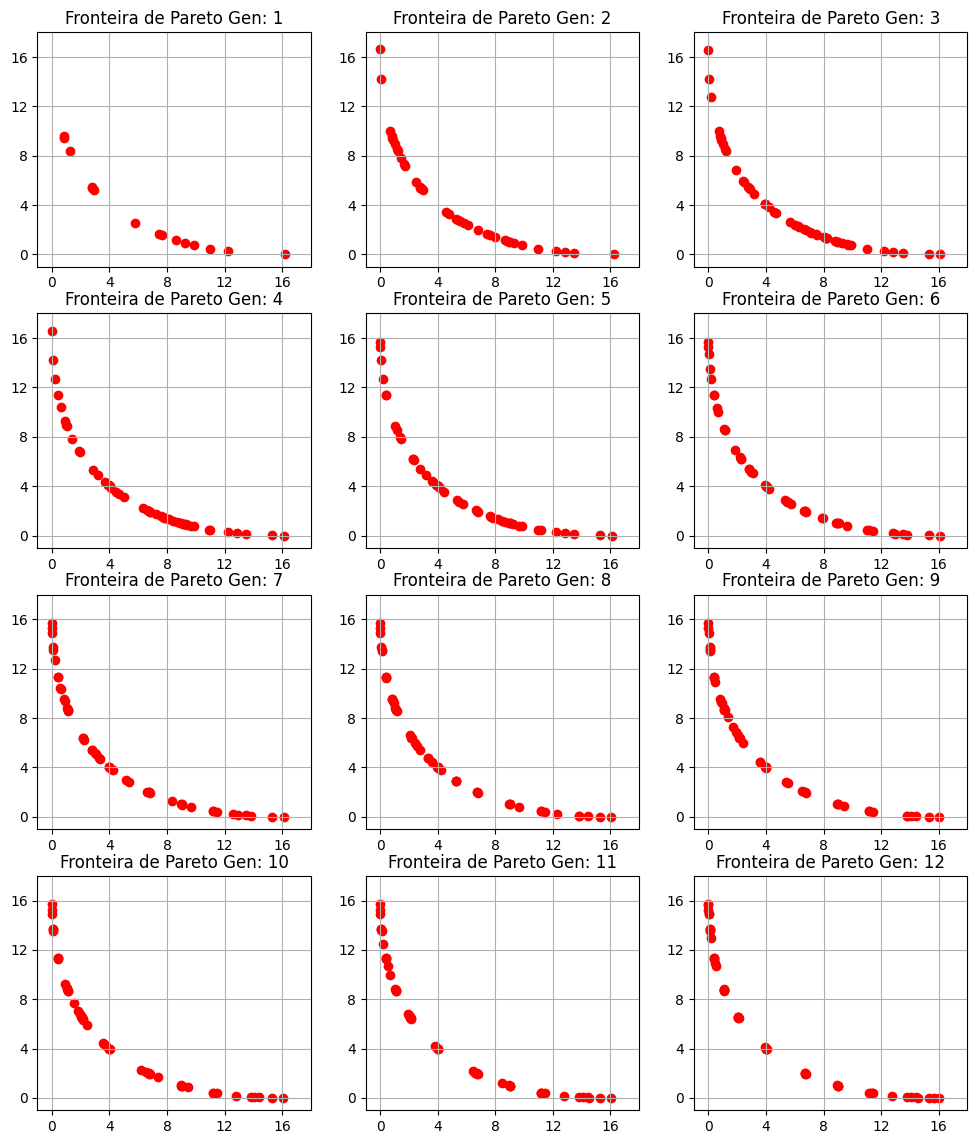

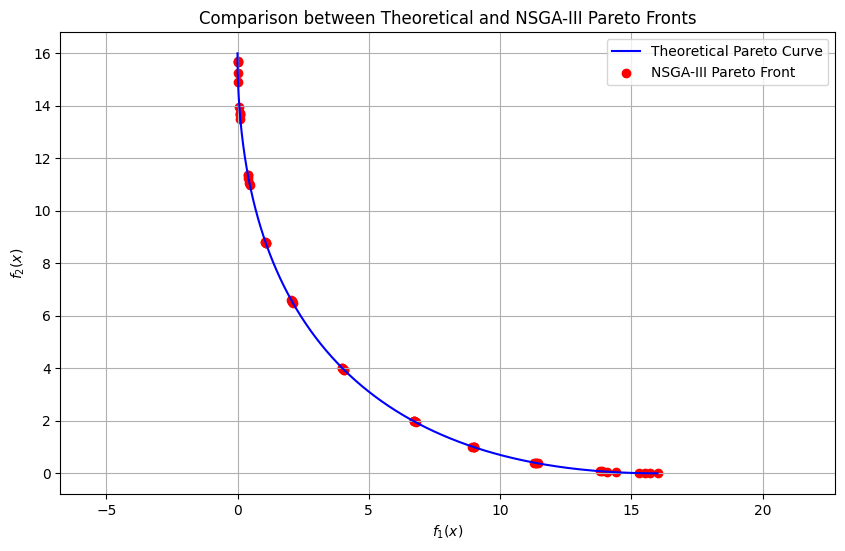

In [11]:
import matplotlib.pyplot as plt

pop_size=50
bounds=(-10, 10)
divisions=10
base_mutation_rate=0.1
generations = 12
population = initialize_population(pop_size, bounds)
M = 2  # Number of objectives
reference_points = generate_reference_points(M, divisions)

plt.figure(figsize=(12,14))
    
# NSGA-III Algorithm
for gen in range(generations):
    # Evaluate current population
    objectives = evaluate_population(population)
    # Non-dominated sorting
    fronts = fast_nondominated_sort(objectives)
    # Compute individual ranks
    individual_ranks = compute_individual_ranks(fronts)

    # Fronteira de Pareto no espaço de objetivos
    pareto_front = [objectives[i] for i in fronts[0]]
    pareto_front.sort()
    plt.subplot(4, 3, gen+1)
    plt.scatter(*zip(*pareto_front), label="Fronteira de Pareto NSGA", color="red")
    plt.title(f"Fronteira de Pareto Gen: {gen+1}")
    plt.grid()
    plt.xticks(np.arange(0, 20, 4)) 
    plt.yticks(np.arange(0, 20, 4)) 
    plt.xlim([-1, 18])
    plt.ylim([-1, 18])
    
    # Generate offspring
    offspring_population = []
    while len(offspring_population) < pop_size:
        # Selection
        parent1 = tournament_selection(population, individual_ranks)
        parent2 = tournament_selection(population, individual_ranks)
        # Crossover
        child = crossover(parent1, parent2)
        # Mutation
        mutation_rate = base_mutation_rate * (1 - gen / generations)
        child = mutation(child, bounds, mutation_rate)
        offspring_population.append(child)

    # Combine populations
    combined_population = population + offspring_population
    # Evaluate combined population
    combined_objectives = evaluate_population(combined_population)
    # Non-dominated sorting on combined population
    combined_fronts = fast_nondominated_sort(combined_objectives)
    # Environmental selection
    population = environmental_selection(combined_population, combined_objectives, combined_fronts, reference_points, pop_size)

# Final evaluation
objectives = evaluate_population(population)
fronts = fast_nondominated_sort(objectives)
pareto_front = [objectives[i] for i in fronts[0]]
pareto_front.sort()

# Theoretical Pareto curve
x_theoretical = np.linspace(-2, 2, 500)
f1_theoretical = f1(x_theoretical)
f2_theoretical = f2(x_theoretical)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(f1_theoretical, f2_theoretical, label="Theoretical Pareto Curve", color="blue")
plt.scatter(*zip(*pareto_front), label="NSGA-III Pareto Front", color="red")
plt.title("Comparison between Theoretical and NSGA-III Pareto Fronts")
plt.xlabel("$f_1(x)$")
plt.ylabel("$f_2(x)$")
plt.legend()
plt.axis("equal")
plt.grid()
plt.show()